# Linear Regression Model and LassoCV model for Capstone Project

In [1]:
import pandas as pd
import numpy as np
import sklearn
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from statsmodels.tsa.ar_model import AutoReg as ar
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
monthly_df = pd.read_json("monthly_data.json")
monthly_df.drop(['Real Gross Domestic Product'],axis=1, inplace=True)
monthly_df

,10-Year Treasury Constant Maturity Rate,Consumer Price Index for all Urban Consumers,Inflation Expectations,Consumer Sentiment & Consumer Confidence,Advance Retail Sales: Retail Trade,Unemployment Rate,VTI,VGT,VIS,VHT,VFH,VCR,date
0,4.420000,198.300000,3.000000,91.200000,286152.000000,4.700000,127.300003,50.330002,58.570000,55.029999,56.869999,53.500000,2006-01-01
1,4.570000,198.700000,3.000000,86.700000,282417.000000,4.800000,127.580002,49.770000,60.299999,55.619999,57.970001,53.740101,2006-02-01
2,4.720000,199.800000,3.000000,88.900000,326153.000000,4.700000,129.669998,50.939999,63.070000,55.209999,58.369999,54.599998,2006-03-01
3,4.990000,201.500000,3.300000,87.400000,316526.000000,4.700000,130.910004,50.509998,64.360001,53.400002,60.090000,55.000000,2006-04-01
4,5.110000,202.500000,4.000000,79.100000,337393.000000,4.600000,126.690002,46.750000,62.790001,52.090000,57.990002,53.540001,2006-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1.580000,276.589000,4.800000,71.700000,559399.000000,4.600000,236.910004,434.160004,200.649994,258.450012,99.650002,338.809998,2021-10-01
190,1.560000,277.948000,4.900000,67.400000,580162.000000,4.200000,233.449997,447.690002,194.369995,248.179993,94.320000,341.589996,2021-11-01
191,1.470000,278.802000,4.800000,70.600000,641659.000000,3.900000,241.440002,458.170013,202.960007,266.420013,96.570000,340.660004,2021-12-01
192,1.760000,281.148000,3.065625,82.314063,386512.072917,4.000000,226.809998,422.260010,190.229996,245.339996,96.019997,307.440002,2022-01-01


## Checking for collinearity

In [3]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

ETF_stocks = ['VTI','VGT','VIS','VHT','VFH','VCR']
for j in ETF_stocks:
    # get y and X dataframes based on this regression:
    y, x = dmatrices(f'{j} ~' + "+".join([f"Q('{x}')" \
                                          for x in monthly_df.drop(['date', \
                                        'VTI','VGT','VIS','VHT','VFH','VCR'],axis=1).columns]), \
                     monthly_df, return_type='dataframe')
    globals()[f"{j}_vif"] = pd.DataFrame()
    globals()[f"{j}_vif"]["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    globals()[f"{j}_vif"]["features"] = x.columns

In [4]:
VTI_vif.round(1)

,VIF Factor,features
0,1262.8,Intercept
1,4.8,Q('10-Year Treasury Constant Maturity Rate')
2,8.4,Q('Consumer Price Index for all Urban Consumers')
3,2.0,Q('Inflation Expectations')
4,3.5,Q('Consumer Sentiment & Consumer Confidence')
5,4.8,Q('Advance Retail Sales: Retail Trade')
6,2.8,Q('Unemployment Rate')


In [5]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

ETF_stocks = ['VTI','VGT','VIS','VHT','VFH','VCR']
for j in ETF_stocks:
    # get y and X dataframes based on this regression:
    y, x = dmatrices(f'{j} ~' + "+".join([f"Q('{x}')" \
                                        for x in monthly_df.drop(['date', 'Consumer Price Index for all Urban Consumers',\
                                        'VTI','VGT','VIS','VHT','VFH','VCR'],axis=1).columns]), \
                     monthly_df, return_type='dataframe')
    globals()[f"{j}_vif"] = pd.DataFrame()
    globals()[f"{j}_vif"]["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    globals()[f"{j}_vif"]["features"] = x.columns

In [6]:
VTI_vif.round(1)

,VIF Factor,features
0,477.9,Intercept
1,2.5,Q('10-Year Treasury Constant Maturity Rate')
2,1.9,Q('Inflation Expectations')
3,3.3,Q('Consumer Sentiment & Consumer Confidence')
4,3.0,Q('Advance Retail Sales: Retail Trade')
5,2.8,Q('Unemployment Rate')


## Linear Regression and LassoCV models

In [7]:
X = monthly_df.drop(columns=['date','Consumer Price Index for all Urban Consumers','VTI','VGT','VIS','VHT','VFH','VCR'])
Y = monthly_df['VTI']

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.05,shuffle=False)

In [9]:
# Alpha of 5 chosen based on 
hyper_test = LassoCV(alphas=[5], random_state=0).fit(X,Y)
predictions = hyper_test.predict(X_test)
print(f"Coefficients for LassoCV model: {hyper_test.coef_}")
print(f"\nMedian absolute error for LassoCV: {sklearn.metrics.median_absolute_error(Y_test, predictions)}")

Coefficients for LassoCV model: [ 2.41088527e+00  0.00000000e+00  0.00000000e+00  4.38344954e-04
 -5.88677282e+00]

Median absolute error for LassoCV: 35.83428492419793


Text(0, 0.5, 'Predicted VTI closing stock price')

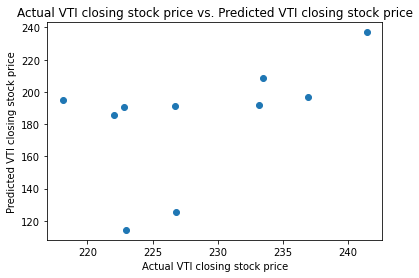

In [10]:
plt.scatter(Y_test.values, predictions)
plt.title("Actual VTI closing stock price vs. Predicted VTI closing stock price")
plt.xlabel("Actual VTI closing stock price")
plt.ylabel("Predicted VTI closing stock price")

Text(0, 0.5, 'Residuals')

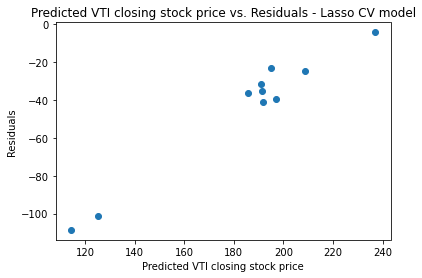

In [11]:
plt.scatter(predictions, predictions - Y_test.values)
plt.title("Predicted VTI closing stock price vs. Residuals - Lasso CV model")
plt.xlabel("Predicted VTI closing stock price")
plt.ylabel("Residuals")

In [12]:
linear_test = sklearn.linear_model.LinearRegression().fit(X_train,Y_train)
linear_predictions = linear_test.predict(X_test)
sklearn.metrics.median_absolute_error(Y_test,linear_predictions)

48.69398797628247

Text(0, 0.5, 'Predicted VTI closing stock price')

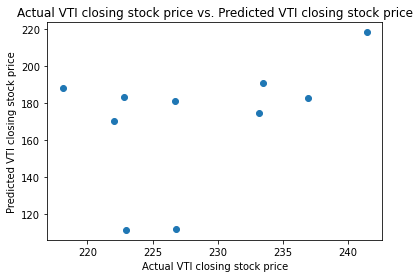

In [13]:
plt.scatter(Y_test.values, linear_predictions)
plt.title("Actual VTI closing stock price vs. Predicted VTI closing stock price")
plt.xlabel("Actual VTI closing stock price")
plt.ylabel("Predicted VTI closing stock price")

Text(0, 0.5, 'Residuals')

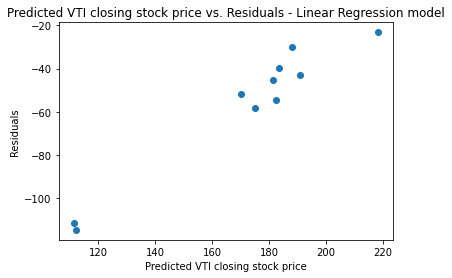

In [14]:
plt.scatter(linear_predictions, linear_predictions - Y_test.values)
plt.title("Predicted VTI closing stock price vs. Residuals - Linear Regression model")
plt.xlabel("Predicted VTI closing stock price")
plt.ylabel("Residuals")

In [15]:
# Auto-regression model used to make future predictions on VTI stock price
res = ar(endog = monthly_df['VTI'], lags = [1,5]).fit()
new_index=[monthly_df.index[-1]+x for x in range(1, 8)]
actual_df_pred=pd.DataFrame(index=new_index,columns=monthly_df.columns)
ar_df = pd.concat([monthly_df, actual_df_pred])
ar_df['predictions']=res.predict(start=monthly_df.shape[0],end=ar_df.shape[0])

# Sets predictions 
for x in list(ar_df.index)[-len(new_index):]:
    ar_df['date'].iloc[x] = ar_df['date'].iloc[x-1] + relativedelta(months=1)

C:\Users\dfbod\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\dfbod\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


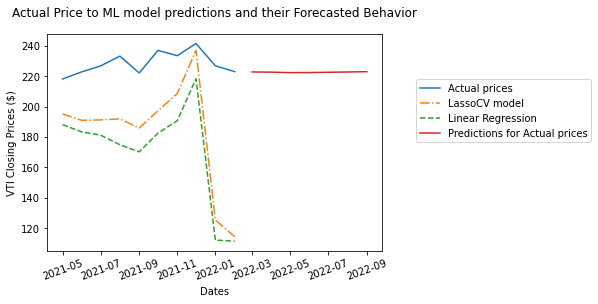

In [16]:
plt.plot(monthly_df['date'][-len(Y_test):].values,Y_test,linestyle='-')
plt.plot(monthly_df['date'][-len(Y_test):].values,predictions,linestyle='-.')
plt.plot(monthly_df['date'][-len(Y_test):].values,linear_predictions,linestyle='--')
plt.plot(ar_df['date'][-len(new_index):].values,ar_df['predictions'][-len(new_index):],linestyle='-')
plt.xlabel('Dates',labelpad=5)
plt.ylabel('VTI Closing Prices ($)')
plt.title('Actual Price to ML model predictions and their Forecasted Behavior',y=1.05)
plt.xticks(rotation=20)
plt.legend(['Actual prices','LassoCV model', 'Linear Regression',
            'Predictions for Actual prices','Predictions for LassoCV model', 'Predictions for Linear Regression model'],loc=(1.1,0.5))

## Uploading models via Joblib

In [17]:
from joblib import dump

dump(hyper_test, "LassoCV model.model")
dump(linear_test, "Linear Regression model.model")

['Linear Regression model.model']